#Sequencing Success: A Hands-On Workshop in Deep Learning for Sequence-to-Sequence Models
Moratuwa Engineering Research Conference 2023 (MERCon 2023) is the 9th international conference organized by the Engineering Research Unit at the University of Moratuwa. As part of MERCon 2023, we are hosting a Hands-On Workshop on Deep Learning for Sequence-to-Sequence Models. This workshop spans four hours and is divided into four one-hour sessions, covering the following topics:
- Introduction to Sequence-to-Sequence Learning
- Sequence-to-Sequence Learning with Recurrent Neural Networks (RNNs)
- Sequence-to-Sequence Learning with Encoder-Decoder Models
- Sequence-to-Sequence Learning with Encoder-Decoder Models and Attention Mechanisms

This notebook is prepared for session **Sequence-to-Sequence Learning with Recurrent Neural Networks**.

All rights reserved.

Authors:
1.   Dr.T.Uthayasanker ([rtuthaya.lk](https://rtuthaya.lk))
2.   Mr.S.Braveenan ([Braveenan Sritharan](https://www.linkedin.com/in/braveenan-sritharan/))

[For more information - MERCon 2023](https://mercon.uom.lk)

#A Simple Seq2Seq Problem: The reverse sequence problem
In this simple Seq2Seq problem, we are provided with a **parallel dataset** comprising two sequences, X (input) and y (output). In this scenario, the output sequence, y[i], is constructed by reversing the order of the elements in the input sequence, X[i]. To illustrate, consider an example where the **input sequence X[i]** has a length of 6, such as:

X[i] = [3, 2, 5, 4, 9, 1]

The corresponding **output sequence, y[i]**, would be:

y[i] = [1, 9, 4, 5, 2, 3]

This problem serves as a foundational example of a Sequence-to-Sequence (Seq2Seq) task, where the objective is to learn to reverse sequences effectively.

In [37]:
#@title Import Libraries
import random
import numpy as np
import matplotlib.pyplot as plt

from keras import Input
from keras.layers import RepeatVector, Dense, SimpleRNN, GRU, LSTM, TimeDistributed
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.models import Sequential, Model

#Auxiliary functions

Here's a brief introduction to each of the functions in this section:


1. **generate_sequence(length, n_unique)**: This function generates a random sequence of specified length with values between 0 and n_unique-1.
2. **one_hot_encode(sequence, n_unique)**: It one-hot encodes a sequence, converting it into a binary matrix where each value in the sequence corresponds to a unique position in the binary matrix.
3. **one_hot_decode(encoded_seq)**: This function reverses the one-hot encoding process, converting a one-hot encoded sequence back into its original numeric form.
4. **get_reversed_pairs(time_steps, vocabulary_size, verbose)**: This function creates a pair of sequences, where one is a random sequence, and the other is its reverse. It returns the one-hot encoded forms of these sequences as well as reshapes them into 3D arrays.
5. **create_dataset(train_size, test_size, time_steps, vocabulary_size, verbose)**: This function generates a dataset of reverse sequence pairs for training and testing. It returns the one-hot encoded training and testing data.
6. **train_test(model, X_train, y_train, X_test, y_test, epochs=100, verbose=0)**: This function trains a provided model using the training data and evaluates its performance on the testing data. It includes early stopping to prevent overfitting and provides accuracy results.
7. **visualize_history(history)**: This function visualizes the training history of a model by plotting accuracy and loss curves over epochs.
8. **check_samples(model, X_test, y_test, num_samples=10)**: It randomly selects a few samples from the testing data, makes predictions using the model, and compares the expected and predicted sequences, displaying the results.

These functions collectively help you generate data, train and evaluate a Seq2Seq model for the reverse sequence problem, and visualize the training history and sample predictions.

In [38]:
#@title Function to generate a sequence of random integers
# generate sequence
def generate_sequence(length, n_unique):
    return [random.randint(0, n_unique-1) for _ in range(length)]

In [39]:
#@title Function to encode and decode sequence data
# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return np.array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [np.argmax(vector) for vector in encoded_seq]

In [40]:
#@title Function to generate reverse pair dataset
# create one reverse pair
def get_reversed_pairs(time_steps,vocabulary_size,verbose= False):
	# generate random sequence
	sequence_in = generate_sequence(time_steps, vocabulary_size)
	sequence_out = sequence_in[::-1]

	# one hot encode
	X = one_hot_encode(sequence_in, vocabulary_size)
	y = one_hot_encode(sequence_out, vocabulary_size)
	# reshape as 3D
	X = X.reshape((1, X.shape[0], X.shape[1]))
	y = y.reshape((1, y.shape[0], y.shape[1]))

	if(verbose):
		print('\nSample X and y')
		print('\nIn raw format:')
		print('X[0]=%s, y[0]=%s' % (one_hot_decode(X[0]), one_hot_decode(y[0])))
		print('\nIn one_hot_encoded format:')
		print('X[0]=%s' % (X[0]))
		print('y[0]=%s' % (y[0]))
	return X,y

# create final dataset
def create_dataset(train_size, test_size, time_steps,vocabulary_size, verbose= False):
	pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
	pairs=np.array(pairs).squeeze()
	X_train = pairs[:,0]
	y_train = pairs[:,1]
	pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
	pairs=np.array(pairs).squeeze()
	X_test = pairs[:,0]
	y_test = pairs[:,1]

	if(verbose):
		print('\nGenerated sequence datasets as follows')
		print('X_train.shape: ', X_train.shape,'y_train.shape: ', y_train.shape)
		print('X_test.shape: ', X_test.shape,'y_test.shape: ', y_test.shape)

	return X_train, y_train, X_test, 	y_test

In [41]:
#@title Function to train and evaluate model
def train_test(model, X_train, y_train , X_test, y_test, epochs=100, verbose=0):
    # patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

    # train model
    print('training for ',epochs,' epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....')
    history = model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, verbose=verbose, callbacks=[es])
    print(epochs,' epoch training finished...')

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)

    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))

    return model, history.history

In [42]:
#@title Function to visualize loss and accuracy
def visualize_history(history):
	# summarize history for accuracy
	plt.plot(history['accuracy'])
	plt.plot(history['val_accuracy'])
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history['loss'])
	plt.plot(history['val_loss'])
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()

In [43]:
#@title Function to check some examples
def check_samples(model, X_test, y_test, num_samples=10):
    sample_indices = random.sample(range(len(X_test)), num_samples)

    for id in sample_indices:
        X, y = X_test[id], y_test[id]
        X = np.expand_dims(X, axis=0)
        y = np.expand_dims(y, axis=0)
        yhat = model.predict(X, verbose=0)
        print(f"Input: {one_hot_decode(X[0])} \nExpected: {one_hot_decode(y[0])} \nPredicted: {one_hot_decode(yhat[0])} \n{np.array_equal(one_hot_decode(y[0]), one_hot_decode(yhat[0]))}\n")

#Create reverse sequence dataset


The provided code snippet establishes default configuration parameters for a sequence manipulation problem. These parameters include the length of the input sequence, the number of unique features, and the sizes of the training and testing datasets. The code then generates random sequences based on these parameters and showcases the generated sequences in both raw and one-hot encoded formats. Additionally, the code creates complete datasets for training and testing, displaying their dimensions. This code serves as an initial setup for working with sequence manipulation tasks, enabling the generation of data and parameter settings for further development and experimentation.

In [44]:
#@title Generating dataset
# Default configuration parameters
n_timesteps_in = 18
n_features = 10
train_size = 20000
test_size = 200

# Generate random sequence using specified parameters
X, y = get_reversed_pairs(n_timesteps_in, n_features, verbose=True)

# Generate datasets using specified parameters
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in, n_features, verbose=True)


Sample X and y

In raw format:
X[0]=[5, 5, 9, 6, 4, 5, 2, 9, 6, 6, 0, 0, 1, 8, 0, 1, 4, 5], y[0]=[5, 4, 1, 0, 8, 1, 0, 0, 6, 6, 9, 2, 5, 4, 6, 9, 5, 5]

In one_hot_encoded format:
X[0]=[[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]]
y[0]=[[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0]
 [0

#1. Multi-Layer Perceptron network model

In your initial solution to the reverse sequence problem, a Multi-Layer Perceptron (MLP) network model has been employed, consisting of input, hidden, and output layers. The model is trained with categorical cross-entropy loss and optimized using Adam. It is evaluated on the datasets you created, and its training history is visualized. This MLP approach serves as an introductory solution for addressing the reverse sequence problem, using the datasets you generated, and provides insights into how well a simple feedforward neural network can perform on this task.

Model: "model_Multi_Layer_Perceptron"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 18, 32)         │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 18, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 18, 10)         │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,050 (4.10 KB)

 Trainable params: 1,050 (4.10 KB)

 Non-trainable params: 0 (0.00 B)

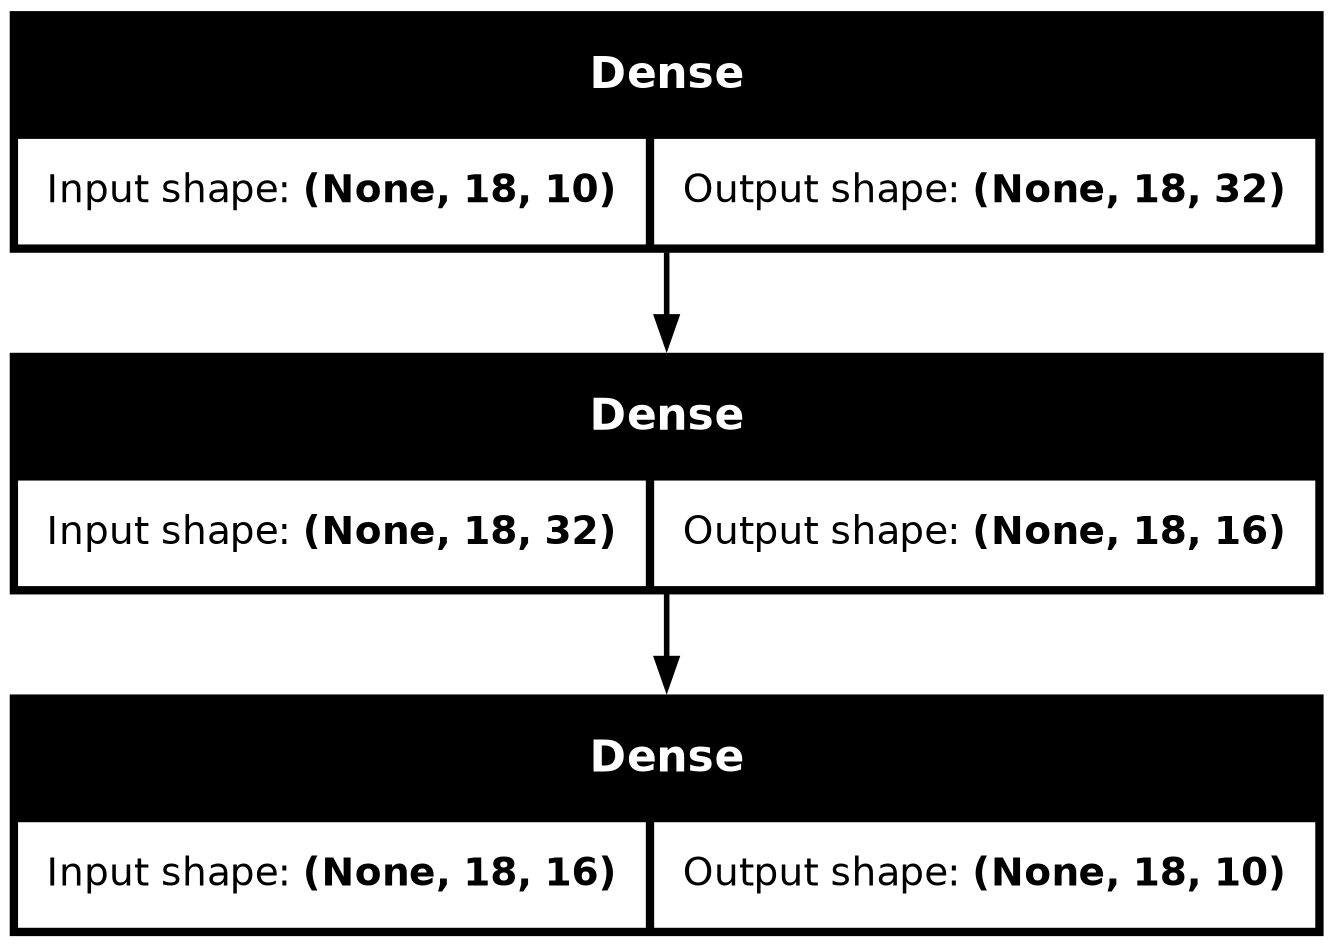

In [45]:
#@title Create Multi-Layer Perceptron network model
numberOfPerceptrons=16
model_Multi_Layer_Perceptron = Sequential(name='model_Multi_Layer_Perceptron')
model_Multi_Layer_Perceptron.add(Input(shape=(n_timesteps_in, n_features)))
model_Multi_Layer_Perceptron.add(Dense(2*numberOfPerceptrons))
model_Multi_Layer_Perceptron.add(Dense(numberOfPerceptrons))
model_Multi_Layer_Perceptron.add(Dense(n_features, activation='softmax'))

model_Multi_Layer_Perceptron.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_Multi_Layer_Perceptron.summary()
plot_model(model_Multi_Layer_Perceptron,show_shapes=True)

In [46]:
#@title Train and Evaluate Multi-Layer Perceptron network model
trained_model_mlp, history_mlp = train_test(model_Multi_Layer_Perceptron, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 3s - 5ms/step - accuracy: 0.0994 - loss: 2.3052 - val_accuracy: 0.0974 - val_loss: 2.3033
Epoch 2/100
563/563 - 1s - 3ms/step - accuracy: 0.1010 - loss: 2.3032 - val_accuracy: 0.0974 - val_loss: 2.3031
Epoch 3/100
563/563 - 1s - 3ms/step - accuracy: 0.1001 - loss: 2.3032 - val_accuracy: 0.0989 - val_loss: 2.3032
Epoch 4/100
563/563 - 2s - 3ms/step - accuracy: 0.1002 - loss: 2.3031 - val_accuracy: 0.1006 - val_loss: 2.3030
Epoch 5/100
563/563 - 1s - 3ms/step - accuracy: 0.1011 - loss: 2.3030 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 6/100
563/563 - 2s - 3ms/step - accuracy: 0.0998 - loss: 2.3031 - val_accuracy: 0.0997 - val_loss: 2.3029
Epoch 7/100
563/563 - 2s - 3ms/step - accuracy: 0.1003 - loss: 2.3030 - val_accuracy: 0.0975 - val_loss: 2.3034
Epoch 8/100
563/563 - 2s - 3ms/step - accuracy: 0.1002 - loss: 2.3030 - val_accuracy: 0.1004 - val_loss:

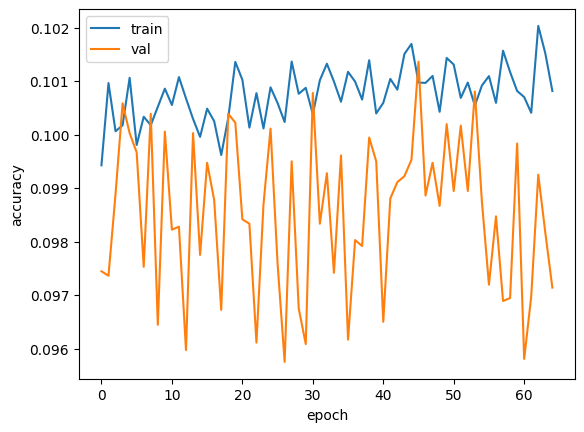

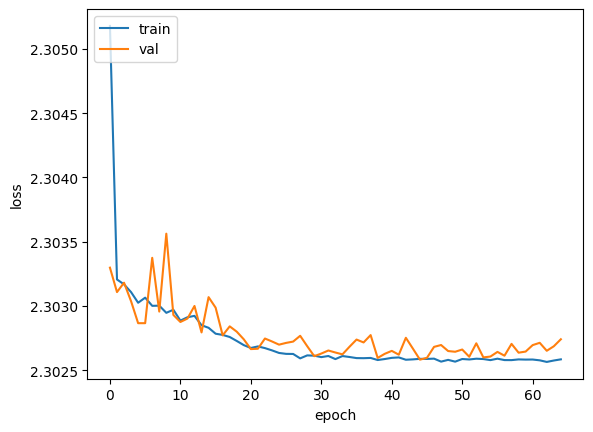

In [47]:
#@title Visualize training and validation Multi-Layer Perceptron network model
visualize_history(history_mlp)

In [48]:
#@title Check random samples Multi-Layer Perceptron network model
check_samples(trained_model_mlp, X_test, y_test, num_samples=10)

Input: [2, 5, 6, 2, 0, 1, 3, 1, 9, 4, 3, 7, 2, 1, 5, 2, 6, 5] 
Expected: [5, 6, 2, 5, 1, 2, 7, 3, 4, 9, 1, 3, 1, 0, 2, 6, 5, 2] 
Predicted: [0, 0, 0, 0, 7, 0, 5, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0] 
False

Input: [4, 8, 9, 5, 2, 2, 2, 2, 2, 6, 0, 1, 4, 0, 5, 4, 0, 1] 
Expected: [1, 0, 4, 5, 0, 4, 1, 0, 6, 2, 2, 2, 2, 2, 5, 9, 8, 4] 
Predicted: [5, 7, 5, 0, 0, 0, 0, 0, 0, 0, 7, 0, 5, 7, 0, 5, 7, 0] 
False

Input: [4, 7, 8, 7, 9, 8, 3, 0, 5, 2, 8, 7, 7, 8, 5, 9, 0, 1] 
Expected: [1, 0, 9, 5, 8, 7, 7, 8, 2, 5, 0, 3, 8, 9, 7, 8, 7, 4] 
Predicted: [5, 0, 7, 0, 5, 7, 5, 7, 0, 0, 7, 0, 0, 7, 0, 5, 7, 0] 
False

Input: [7, 4, 7, 9, 4, 4, 0, 2, 2, 0, 3, 3, 7, 9, 8, 8, 8, 9] 
Expected: [9, 8, 8, 8, 9, 7, 3, 3, 0, 2, 2, 0, 4, 4, 9, 7, 4, 7] 
Predicted: [0, 5, 0, 5, 5, 5, 7, 0, 0, 7, 5, 5, 0, 5, 7, 7, 7, 5] 
False

Input: [1, 4, 8, 7, 6, 3, 1, 5, 1, 6, 7, 4, 3, 3, 3, 5, 0, 2] 
Expected: [2, 0, 5, 3, 3, 3, 4, 7, 6, 1, 5, 1, 3, 6, 7, 8, 4, 1] 
Predicted: [0, 5, 7, 0, 0, 5, 0, 0, 0, 0, 0, 5, 5, 5, 5, 0,

#2. Recurrent Neural Networks

Multi-Layer Perceptrons (MLPs) are great for many tasks, but they don't understand the order of things in a sequence. They treat all data equally. For tasks that involve sequences, like time-related data, we need something smarter. That's where Recurrent Neural Networks (RNNs) come in. RNNs are like the **sequence experts** of neural networks. They know the importance of the order of things. There are different types of RNNs, such as Simple RNNs, Gated Recurrent Units (GRUs), and Long-Short Term Memory (LSTM) networks. These special RNNs are designed to understand and work with sequences, making them perfect for tasks where the order of data matters a lot.

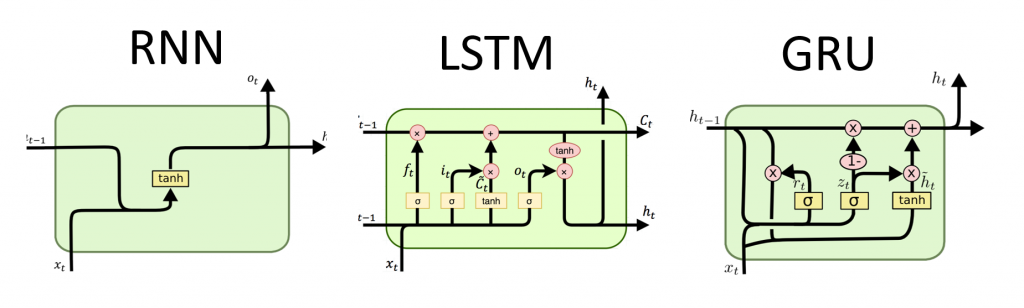

#2.1. Simple Recurrent Neural Network model (RNN)

In this section, we'll be using a Simple Recurrent Neural Network (Simple RNN) to solve the reverse sequence problem. Simple RNNs work a bit like detectives for sequences. They understand the order of things in a sequence because they remember what happened earlier. Simple RNNs keep a hidden memory of past information and use this memory to link input and output in the right order.

Model: "model_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 18, 16)         │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 18, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 18, 10)         │           170 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,130 (4.41 KB)

 Trainable params: 1,130 (4.41 KB)

 Non-trainable params: 0 (0.00 B)

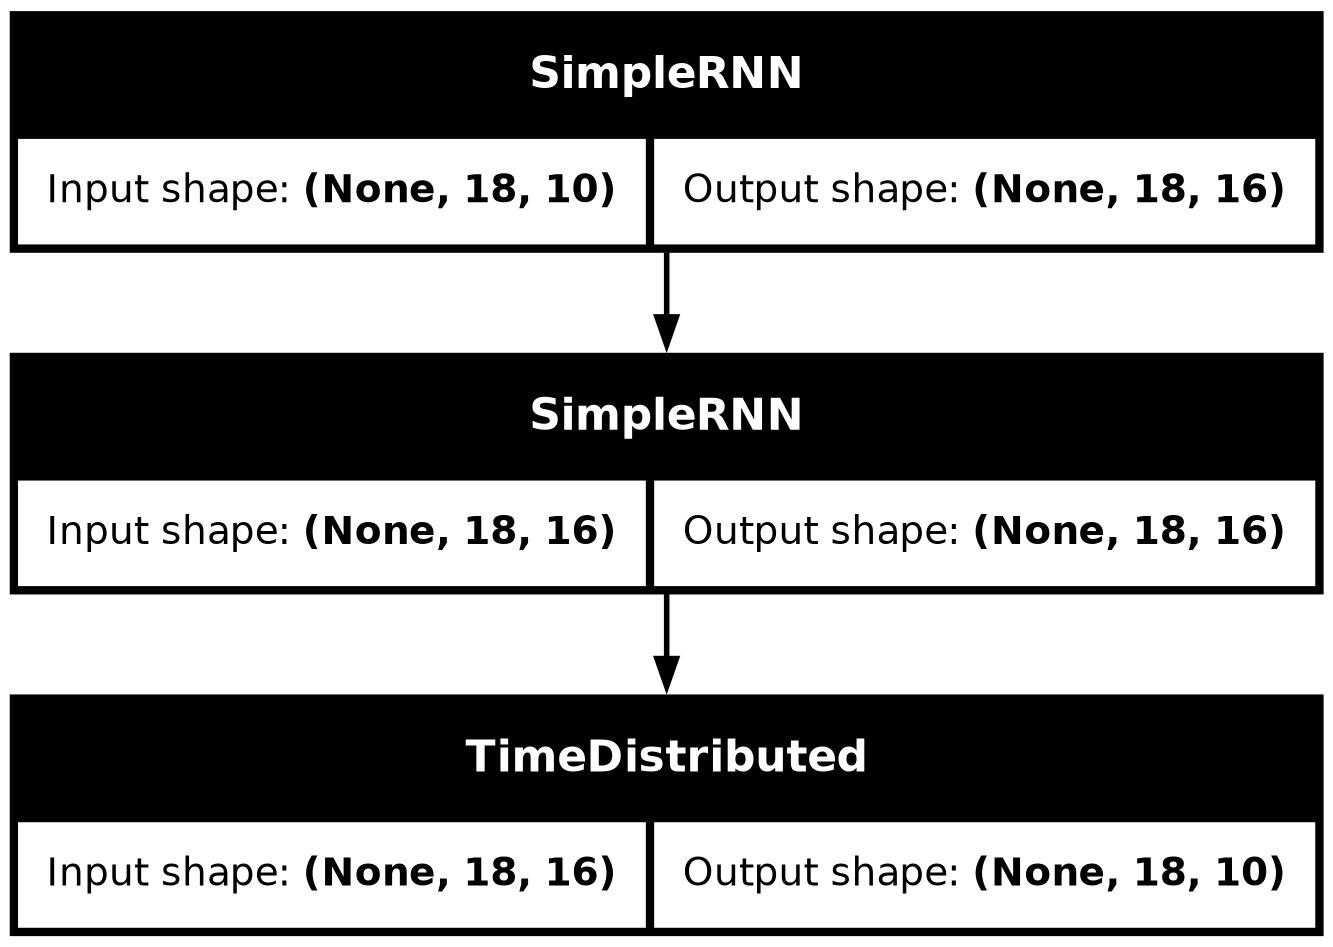

In [49]:
#@title Create simple RNN model
numberOfUnits = 16
model_RNN = Sequential(name='model_RNN')
model_RNN.add(Input(shape=(n_timesteps_in, n_features)))
model_RNN.add(SimpleRNN(numberOfUnits, return_sequences=True))
model_RNN.add(SimpleRNN(numberOfUnits, return_sequences=True))
model_RNN.add(TimeDistributed(Dense(n_features, activation='softmax')))

model_RNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_RNN.summary()
plot_model(model_RNN, show_shapes=True)

In [50]:
#@title Train and Evaluate simple RNN model
trained_model_rnn, history_rnn = train_test(model_RNN, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 9s - 16ms/step - accuracy: 0.1496 - loss: 2.2602 - val_accuracy: 0.1795 - val_loss: 2.1923
Epoch 2/100
563/563 - 5s - 8ms/step - accuracy: 0.1898 - loss: 2.1611 - val_accuracy: 0.1949 - val_loss: 2.1391
Epoch 3/100
563/563 - 5s - 8ms/step - accuracy: 0.2000 - loss: 2.1144 - val_accuracy: 0.2002 - val_loss: 2.1066
Epoch 4/100
563/563 - 5s - 8ms/step - accuracy: 0.2053 - loss: 2.0886 - val_accuracy: 0.2068 - val_loss: 2.0827
Epoch 5/100
563/563 - 5s - 8ms/step - accuracy: 0.2097 - loss: 2.0674 - val_accuracy: 0.2082 - val_loss: 2.0679
Epoch 6/100
563/563 - 5s - 8ms/step - accuracy: 0.2112 - loss: 2.0578 - val_accuracy: 0.2120 - val_loss: 2.0605
Epoch 7/100
563/563 - 5s - 9ms/step - accuracy: 0.2125 - loss: 2.0515 - val_accuracy: 0.2119 - val_loss: 2.0560
Epoch 8/100
563/563 - 5s - 8ms/step - accuracy: 0.2139 - loss: 2.0441 - val_accuracy: 0.2117 - val_loss

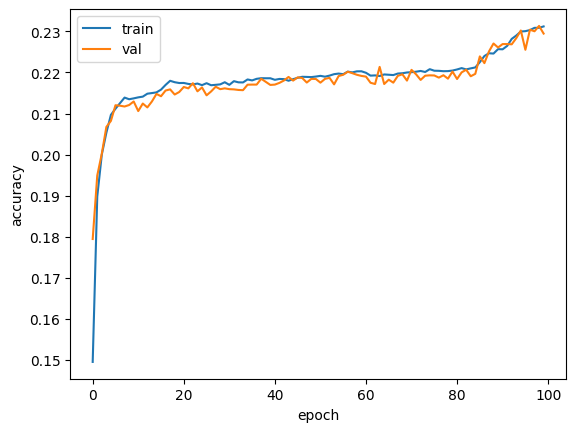

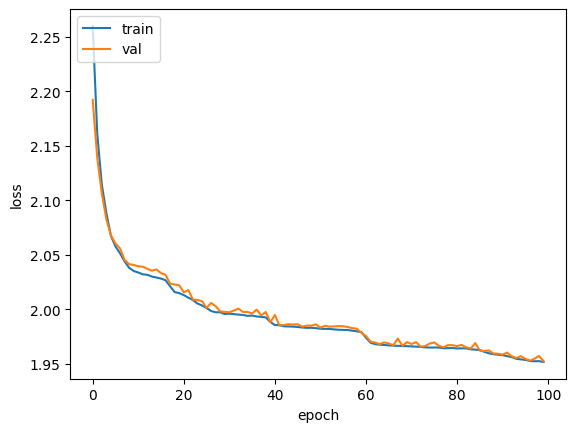

In [51]:
#@title Visualize training and validation simple RNN model
visualize_history(history_rnn)

In [52]:
#@title Check random samples simple RNN model
check_samples(trained_model_rnn, X_test, y_test, num_samples=10)

Input: [0, 6, 5, 3, 6, 2, 3, 2, 5, 0, 9, 3, 9, 5, 8, 2, 1, 5] 
Expected: [5, 1, 2, 8, 5, 9, 3, 9, 0, 5, 2, 3, 2, 6, 3, 5, 6, 0] 
Predicted: [0, 0, 6, 0, 6, 0, 6, 0, 2, 5, 3, 6, 3, 5, 3, 0, 6, 5] 
False

Input: [4, 7, 8, 7, 9, 8, 3, 0, 5, 2, 8, 7, 7, 8, 5, 9, 0, 1] 
Expected: [1, 0, 9, 5, 8, 7, 7, 8, 2, 5, 0, 3, 8, 9, 7, 8, 7, 4] 
Predicted: [3, 4, 7, 4, 7, 4, 7, 4, 7, 4, 7, 4, 7, 4, 7, 4, 7, 4] 
False

Input: [4, 3, 7, 0, 9, 2, 5, 5, 4, 0, 7, 3, 6, 9, 7, 1, 9, 0] 
Expected: [0, 9, 1, 7, 9, 6, 3, 7, 0, 4, 5, 5, 2, 9, 0, 7, 3, 4] 
Predicted: [3, 4, 3, 7, 3, 4, 3, 4, 3, 4, 0, 4, 3, 4, 3, 4, 3, 4] 
False

Input: [7, 3, 4, 0, 9, 5, 6, 5, 3, 5, 4, 6, 7, 1, 1, 6, 6, 1] 
Expected: [1, 6, 6, 1, 1, 7, 6, 4, 5, 3, 5, 6, 5, 9, 0, 4, 3, 7] 
Predicted: [0, 7, 3, 7, 3, 7, 0, 7, 5, 7, 5, 4, 5, 7, 5, 7, 5, 7] 
False

Input: [6, 5, 0, 6, 8, 8, 4, 2, 1, 2, 5, 9, 8, 4, 9, 6, 4, 1] 
Expected: [1, 4, 6, 9, 4, 8, 9, 5, 2, 1, 2, 4, 8, 8, 6, 0, 5, 6] 
Predicted: [0, 6, 5, 6, 5, 6, 5, 0, 5, 0, 5, 6, 5, 6, 5, 6,

#2.2. Gated Recurrent Units model (GRU)

In this section, we will use Gated Recurrent Units (GRUs) to address some of the issues we encountered with Simple RNN. You see, Simple RNNs can forget important details when working with long sequences, which makes them less effective. GRUs feature a more intelligent architecture that helps them remember and utilize information more effectively. They incorporate **gates** that control what they remember and what they forget, making them excellent at understanding both short and long patterns in sequences.

Model: "model_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 18, 16)         │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 18, 16)         │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 18, 10)         │           170 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,146 (12.29 KB)

 Trainable params: 3,146 (12.29 KB)

 Non-trainable params: 0 (0.00 B)

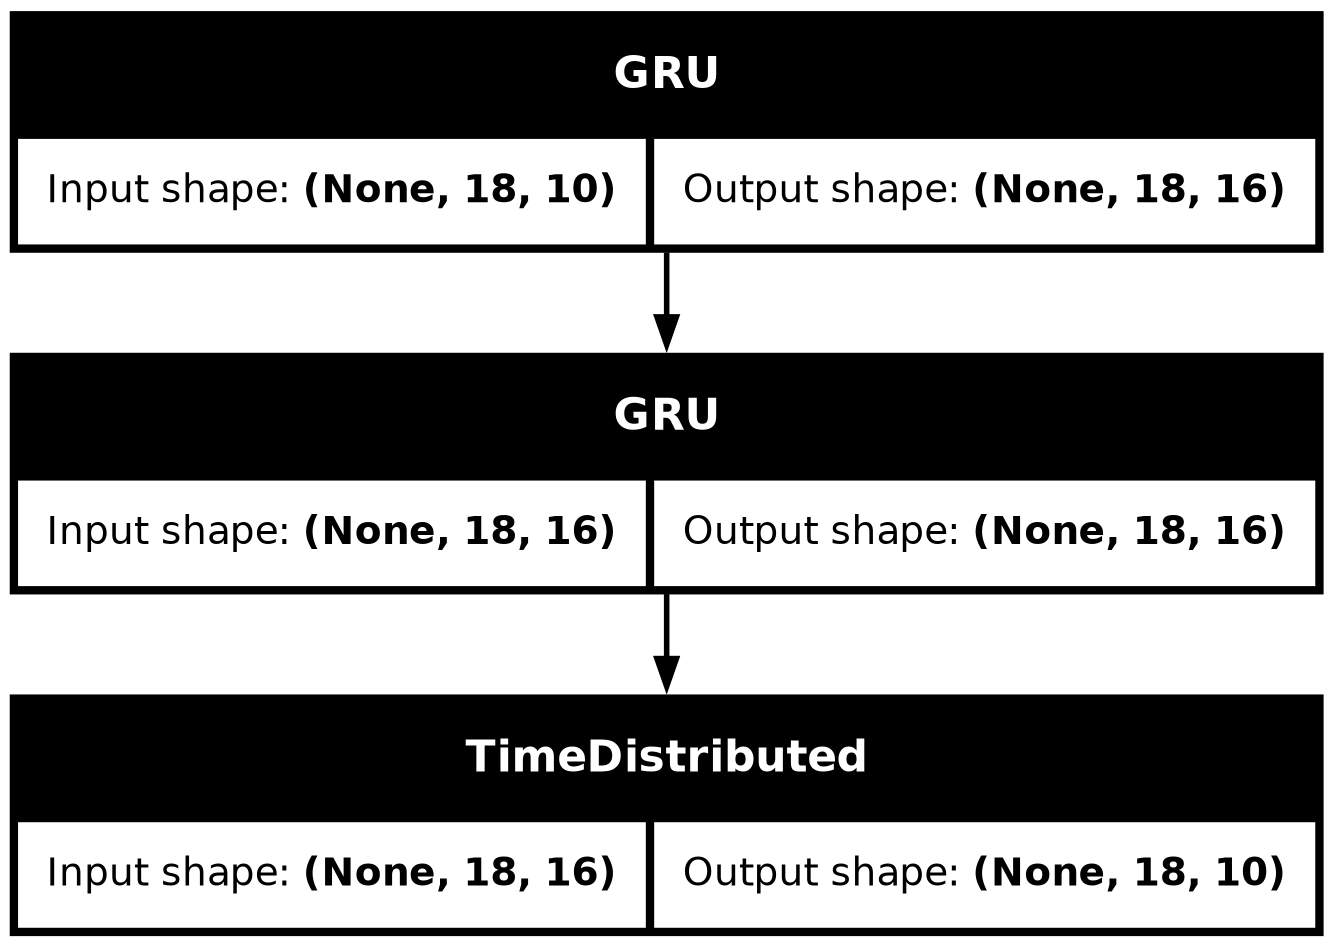

In [53]:
#@title Create GRU model
numberOfUnits = 16
model_GRU = Sequential(name='model_GRU')
model_GRU.add(Input(shape=(n_timesteps_in, n_features)))
model_GRU.add(GRU(numberOfUnits, return_sequences=True))
model_GRU.add(GRU(numberOfUnits, return_sequences=True))
model_GRU.add(TimeDistributed(Dense(n_features, activation='softmax')))

model_GRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_GRU.summary()
plot_model(model_GRU, show_shapes=True)

In [54]:
#@title Train and Evaluate GRU model
trained_model_gru, history_gru = train_test(model_GRU, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 14s - 25ms/step - accuracy: 0.1496 - loss: 2.2372 - val_accuracy: 0.1710 - val_loss: 2.1768
Epoch 2/100
563/563 - 9s - 16ms/step - accuracy: 0.1785 - loss: 2.1501 - val_accuracy: 0.1767 - val_loss: 2.1303
Epoch 3/100
563/563 - 9s - 16ms/step - accuracy: 0.1828 - loss: 2.1163 - val_accuracy: 0.1812 - val_loss: 2.1090
Epoch 4/100
563/563 - 9s - 16ms/step - accuracy: 0.1849 - loss: 2.1004 - val_accuracy: 0.1835 - val_loss: 2.0975
Epoch 5/100
563/563 - 9s - 16ms/step - accuracy: 0.1860 - loss: 2.0910 - val_accuracy: 0.1852 - val_loss: 2.0859
Epoch 6/100
563/563 - 9s - 16ms/step - accuracy: 0.1867 - loss: 2.0838 - val_accuracy: 0.1848 - val_loss: 2.0825
Epoch 7/100
563/563 - 9s - 16ms/step - accuracy: 0.1872 - loss: 2.0777 - val_accuracy: 0.1851 - val_loss: 2.0765
Epoch 8/100
563/563 - 9s - 16ms/step - accuracy: 0.1875 - loss: 2.0722 - val_accuracy: 0.1867 - 

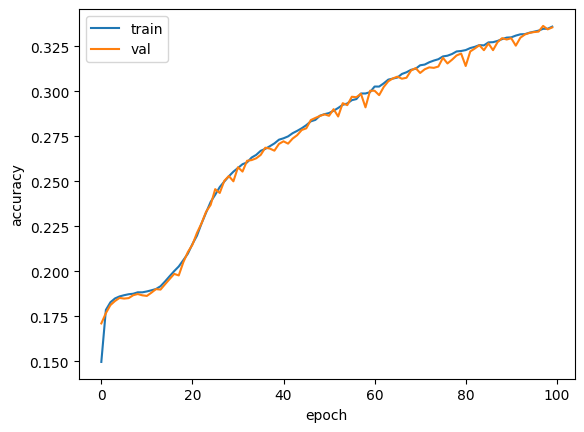

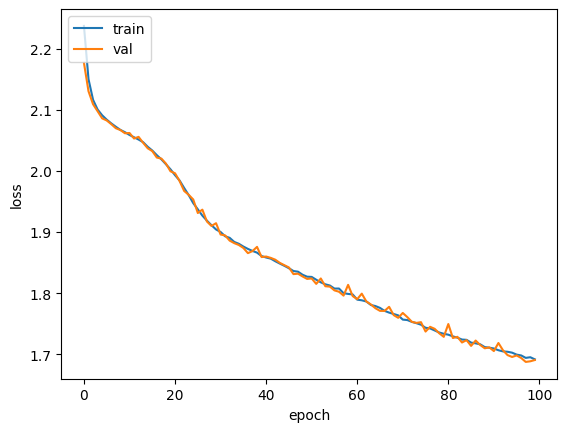

In [55]:
#@title Visualize training and validation GRU model
visualize_history(history_gru)

In [56]:
#@title Check random samples GRU model
check_samples(trained_model_gru, X_test, y_test, num_samples=10)

Input: [8, 1, 5, 8, 8, 9, 7, 0, 0, 3, 4, 1, 9, 5, 8, 6, 3, 9] 
Expected: [9, 3, 6, 8, 5, 9, 1, 4, 3, 0, 0, 7, 9, 8, 8, 5, 1, 8] 
Predicted: [8, 8, 8, 8, 1, 1, 1, 1, 7, 7, 7, 7, 1, 1, 1, 8, 8, 1] 
False

Input: [8, 8, 2, 7, 0, 7, 1, 3, 2, 9, 0, 9, 2, 3, 2, 0, 9, 0] 
Expected: [0, 9, 0, 2, 3, 2, 9, 0, 9, 2, 3, 1, 7, 0, 7, 2, 8, 8] 
Predicted: [8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 3, 7, 7, 7, 7, 2, 0, 8] 
False

Input: [9, 9, 4, 2, 8, 8, 0, 6, 5, 9, 1, 0, 9, 0, 1, 7, 9, 6] 
Expected: [6, 9, 7, 1, 0, 9, 0, 1, 9, 5, 6, 0, 8, 8, 2, 4, 9, 9] 
Predicted: [0, 5, 5, 5, 9, 9, 9, 9, 5, 5, 5, 8, 9, 8, 2, 4, 9, 9] 
False

Input: [8, 5, 8, 9, 2, 2, 4, 2, 8, 2, 5, 7, 4, 1, 8, 7, 3, 9] 
Expected: [9, 3, 7, 8, 1, 4, 7, 5, 2, 8, 2, 4, 2, 2, 9, 8, 5, 8] 
Predicted: [8, 8, 8, 9, 6, 6, 6, 2, 2, 2, 2, 4, 2, 2, 8, 8, 8, 8] 
False

Input: [7, 5, 6, 6, 8, 8, 8, 4, 2, 6, 9, 3, 5, 2, 2, 2, 3, 7] 
Expected: [7, 3, 2, 2, 2, 5, 3, 9, 6, 2, 4, 8, 8, 8, 6, 6, 5, 7] 
Predicted: [0, 0, 7, 6, 6, 6, 1, 1, 6, 6, 6, 6, 8, 8, 8, 6,

#2.3. Long Short-Term Memory model (LSTM)

In this section we are going to talk about Long-Short Term Memory (LSTM) networks, which are a special kind of recurrent neural network. Unlike Gated Recurrent Units (GRUs), LSTMs have a more complex structure with three key components that help them remember and understand sequences better. These components are the input gate, the forget gate, and the output gate. They're really good at capturing long-term patterns in data, which is super useful for tasks involving sequences. LSTMs are especially great for dealing with complex sequences, and they can hold on to important information for longer, so nothing important gets forgotten. These unique features make LSTMs an essential tool for handling challenging tasks involving time series data and sequences in the world of deep learning.



Model: "model_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 18, 16)         │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 18, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 18, 10)         │           170 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,010 (15.66 KB)

 Trainable params: 4,010 (15.66 KB)

 Non-trainable params: 0 (0.00 B)

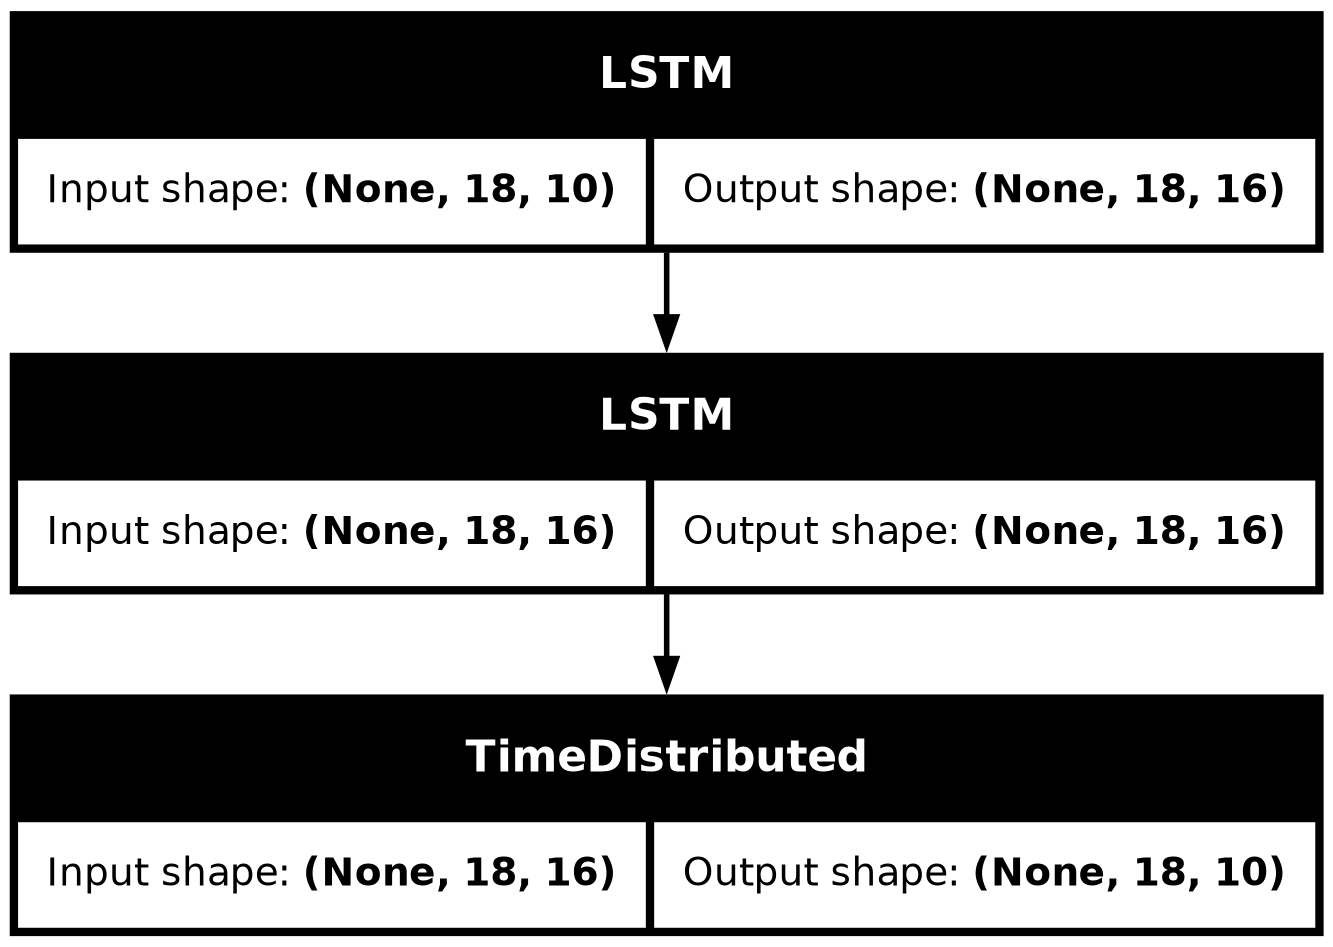

In [57]:
#@title Create LSTM model
numberOfUnits = 16
model_LSTM = Sequential(name='model_LSTM')
model_LSTM.add(Input(shape=(n_timesteps_in, n_features)))
model_LSTM.add(LSTM(numberOfUnits,return_sequences=True))
model_LSTM.add(LSTM(numberOfUnits,return_sequences=True))
model_LSTM.add(TimeDistributed(Dense(n_features, activation='softmax')))

model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM.summary()
plot_model(model_LSTM,show_shapes=True)

In [58]:
#@title Train and Evaluate LSTM model
trained_model_lstm, history_lstm = train_test(model_LSTM, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 13s - 24ms/step - accuracy: 0.1623 - loss: 2.1968 - val_accuracy: 0.1772 - val_loss: 2.1363
Epoch 2/100
563/563 - 8s - 14ms/step - accuracy: 0.1842 - loss: 2.1092 - val_accuracy: 0.1840 - val_loss: 2.0969
Epoch 3/100
563/563 - 8s - 14ms/step - accuracy: 0.1890 - loss: 2.0822 - val_accuracy: 0.1882 - val_loss: 2.0740
Epoch 4/100
563/563 - 8s - 14ms/step - accuracy: 0.1963 - loss: 2.0605 - val_accuracy: 0.1971 - val_loss: 2.0549
Epoch 5/100
563/563 - 8s - 14ms/step - accuracy: 0.2030 - loss: 2.0420 - val_accuracy: 0.2041 - val_loss: 2.0356
Epoch 6/100
563/563 - 8s - 14ms/step - accuracy: 0.2091 - loss: 2.0258 - val_accuracy: 0.2101 - val_loss: 2.0252
Epoch 7/100
563/563 - 8s - 14ms/step - accuracy: 0.2133 - loss: 2.0119 - val_accuracy: 0.2139 - val_loss: 2.0094
Epoch 8/100
563/563 - 8s - 14ms/step - accuracy: 0.2169 - loss: 1.9992 - val_accuracy: 0.2161 - 

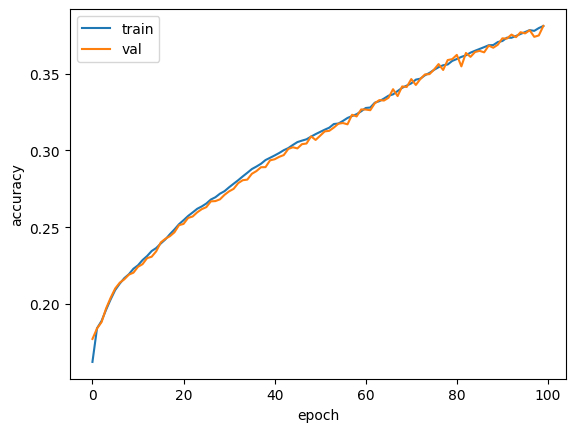

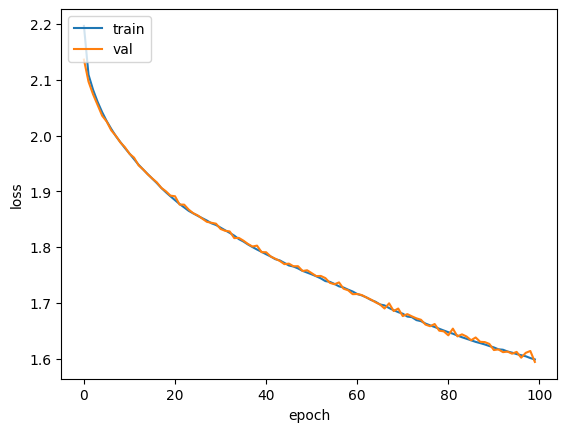

In [59]:
#@title Visualize training and validation LSTM model
visualize_history(history_lstm)

In [60]:
#@title Check random samples LSTM model
check_samples(trained_model_lstm, X_test, y_test, num_samples=10)

Input: [7, 0, 1, 4, 6, 5, 0, 7, 8, 3, 1, 2, 1, 2, 9, 9, 5, 1] 
Expected: [1, 5, 9, 9, 2, 1, 2, 1, 3, 8, 7, 0, 5, 6, 4, 1, 0, 7] 
Predicted: [7, 7, 2, 7, 2, 3, 7, 0, 0, 8, 7, 0, 5, 6, 1, 0, 7, 7] 
False

Input: [4, 8, 8, 3, 3, 9, 2, 6, 4, 2, 9, 3, 5, 1, 9, 7, 5, 1] 
Expected: [1, 5, 7, 9, 1, 5, 3, 9, 2, 4, 6, 2, 9, 3, 3, 8, 8, 4] 
Predicted: [5, 5, 5, 3, 2, 2, 5, 6, 4, 4, 6, 2, 9, 9, 3, 8, 8, 8] 
False

Input: [7, 6, 5, 4, 3, 1, 8, 2, 3, 0, 4, 4, 9, 4, 8, 4, 0, 4] 
Expected: [4, 0, 4, 8, 4, 9, 4, 4, 0, 3, 2, 8, 1, 3, 4, 5, 6, 7] 
Predicted: [7, 7, 7, 2, 2, 2, 5, 5, 5, 3, 7, 5, 7, 1, 3, 4, 6, 7] 
False

Input: [7, 3, 9, 3, 0, 4, 7, 2, 7, 0, 1, 0, 0, 4, 8, 3, 3, 0] 
Expected: [0, 3, 3, 8, 4, 0, 0, 1, 0, 7, 2, 7, 4, 0, 3, 9, 3, 7] 
Predicted: [7, 3, 2, 2, 2, 2, 2, 0, 4, 7, 2, 7, 3, 3, 9, 9, 7, 7] 
False

Input: [7, 3, 4, 8, 4, 2, 3, 1, 9, 1, 9, 5, 9, 2, 8, 4, 2, 1] 
Expected: [1, 2, 4, 8, 2, 9, 5, 9, 1, 9, 1, 3, 2, 4, 8, 4, 3, 7] 
Predicted: [7, 3, 2, 2, 2, 2, 9, 9, 0, 9, 1, 3, 3, 8, 8, 8,

#3. Information Sharing between RNN Layers
Up until now, we've been using a single method: passing all the hidden states from one RNN layer to the next. But now, we're about to learn three more methods for sharing information. These methods work for all RNNs, not just LSTMs. These additional methods include:
1. Sharing only the last hidden state, which represents a part of the information from the current and recent time steps, with the next layer.
2. Sharing both the last hidden state and the last cell state, where the cell state serves as another part of the information and specializes in preserving long-term memory and dependencies.
3. Sharing all the hidden states (representing the previous states in the sequence) and the last cell state.

In this context, it's important to note that while the hidden states capture short-term memory and patterns, the cell state, an integral component, is responsible for managing long-term memory and preserving extended dependencies in the data.

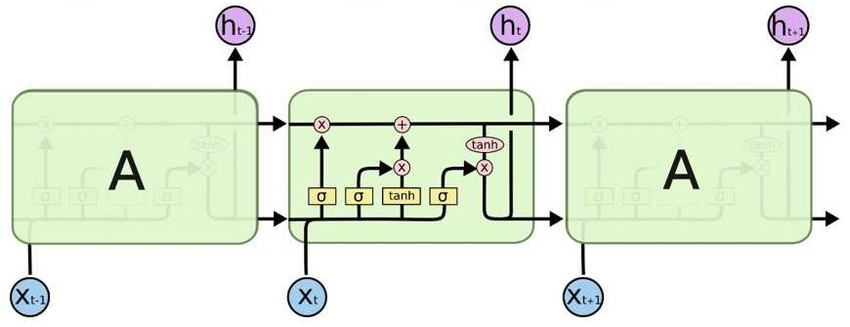

#3.1. LSTM model - Only last hidden state



Model: "model_LSTM_with_last_hidden"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 16)             │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 18, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 18, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 18, 10)         │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,010 (15.66 KB)

 Trainable params: 4,010 (15.66 KB)

 Non-trainable params: 0 (0.00 B)

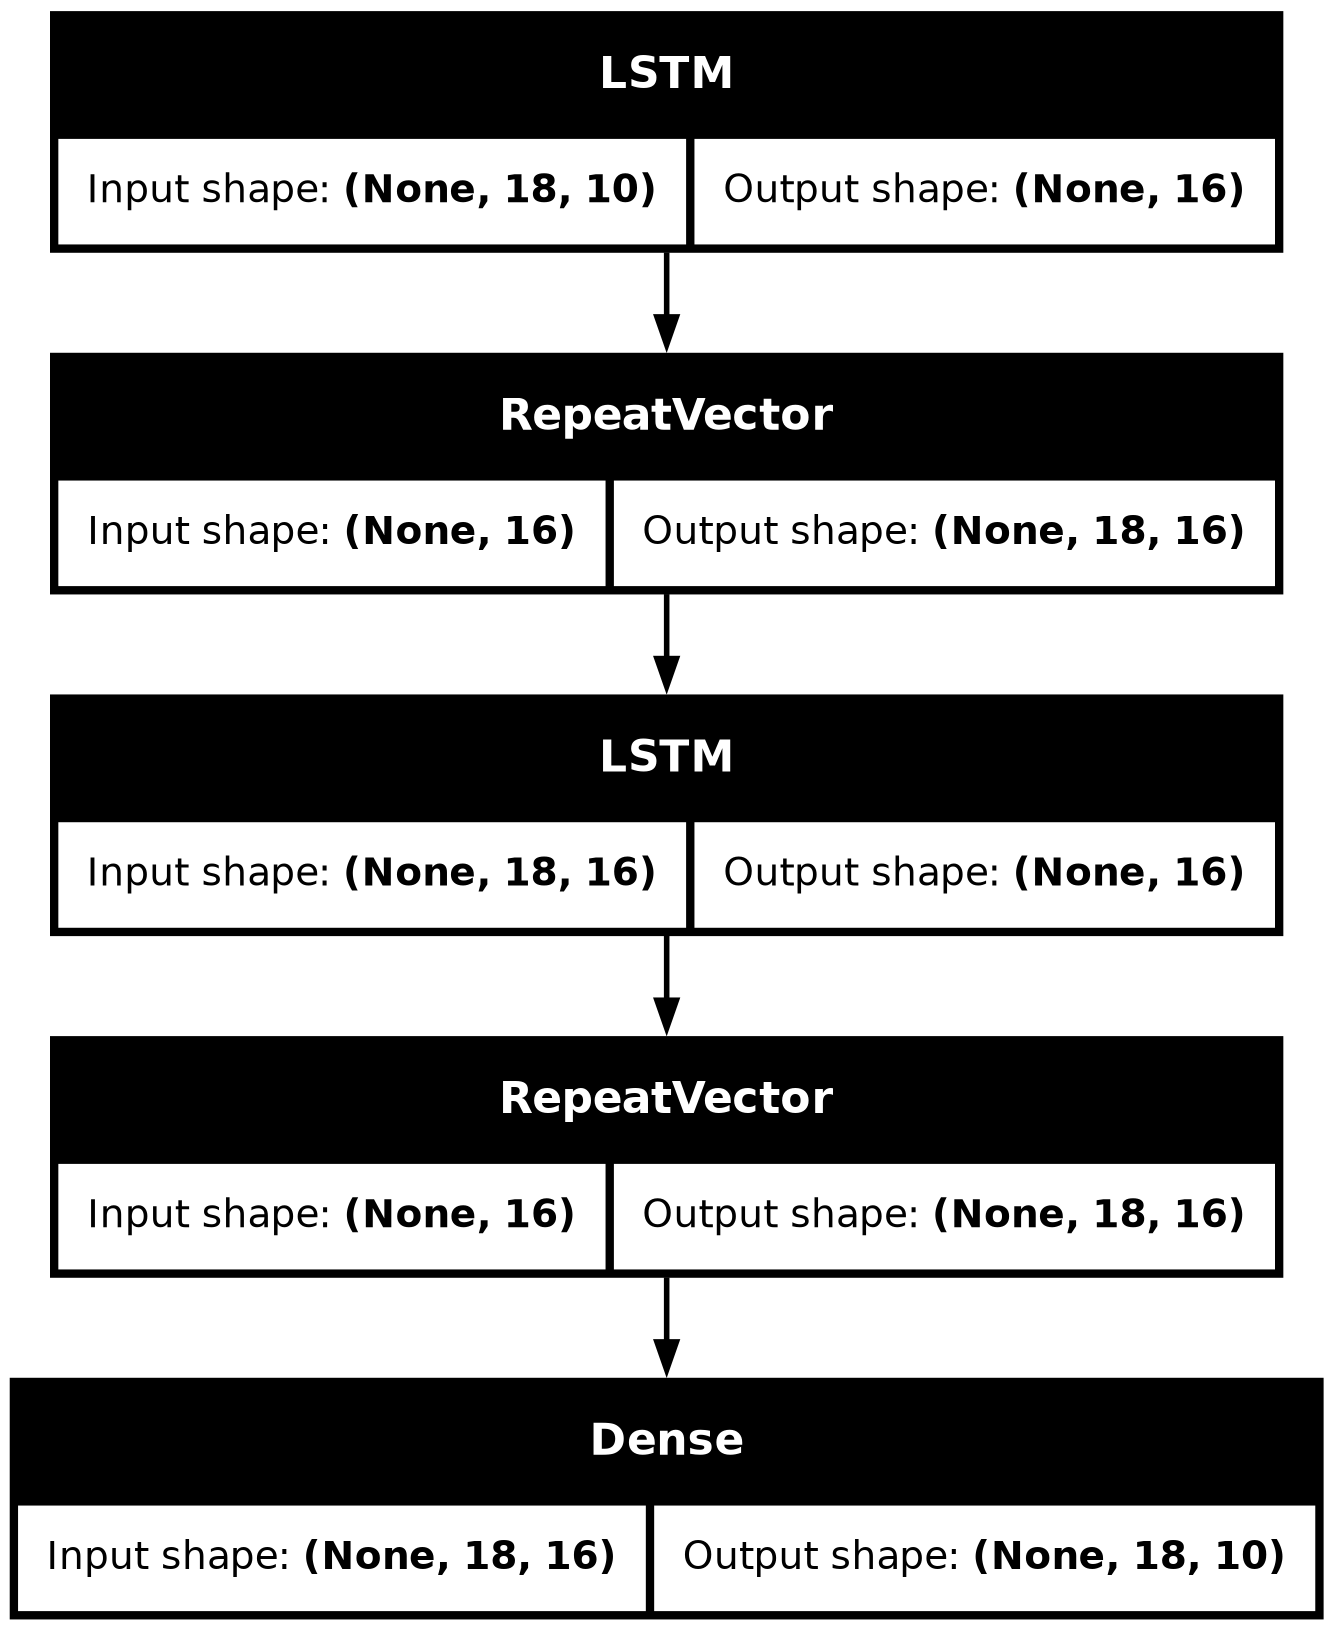

In [61]:
#@title Create LSTM model with only last hidden state
numberOfUnits = 16
model_LSTM_with_last_hidden = Sequential(name='model_LSTM_with_last_hidden')
model_LSTM_with_last_hidden.add(Input(shape=(n_timesteps_in, n_features)))
model_LSTM_with_last_hidden.add(LSTM(numberOfUnits))
model_LSTM_with_last_hidden.add(RepeatVector(n_timesteps_in))
model_LSTM_with_last_hidden.add(LSTM(numberOfUnits))
model_LSTM_with_last_hidden.add(RepeatVector(n_timesteps_in))
model_LSTM_with_last_hidden.add(Dense(n_features, activation='softmax'))


model_LSTM_with_last_hidden.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM_with_last_hidden.summary()
plot_model(model_LSTM_with_last_hidden,show_shapes=True)

In [62]:
#@title Train and Evaluate LSTM model with only last hidden state
trained_model_with_last_hidden, history_with_last_hidden = train_test(model_LSTM_with_last_hidden, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 12s - 21ms/step - accuracy: 0.1947 - loss: 2.1722 - val_accuracy: 0.2156 - val_loss: 2.1114
Epoch 2/100
563/563 - 7s - 13ms/step - accuracy: 0.2234 - loss: 2.0768 - val_accuracy: 0.2239 - val_loss: 2.0580
Epoch 3/100
563/563 - 7s - 13ms/step - accuracy: 0.2257 - loss: 2.0480 - val_accuracy: 0.2236 - val_loss: 2.0450
Epoch 4/100
563/563 - 7s - 13ms/step - accuracy: 0.2259 - loss: 2.0386 - val_accuracy: 0.2236 - val_loss: 2.0381
Epoch 5/100
563/563 - 8s - 14ms/step - accuracy: 0.2259 - loss: 2.0322 - val_accuracy: 0.2238 - val_loss: 2.0325
Epoch 6/100
563/563 - 8s - 13ms/step - accuracy: 0.2261 - loss: 2.0269 - val_accuracy: 0.2242 - val_loss: 2.0273
Epoch 7/100
563/563 - 7s - 13ms/step - accuracy: 0.2263 - loss: 2.0222 - val_accuracy: 0.2243 - val_loss: 2.0232
Epoch 8/100
563/563 - 7s - 13ms/step - accuracy: 0.2265 - loss: 2.0190 - val_accuracy: 0.2244 - 

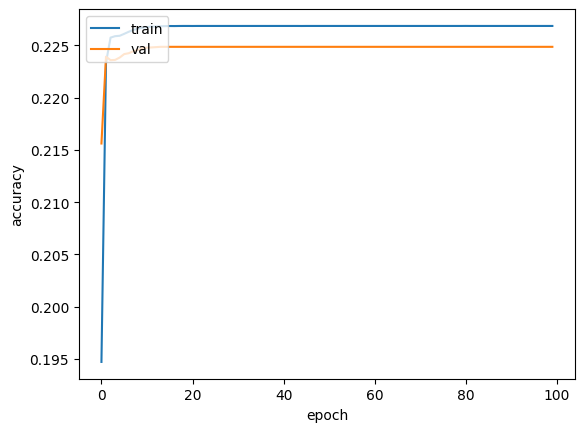

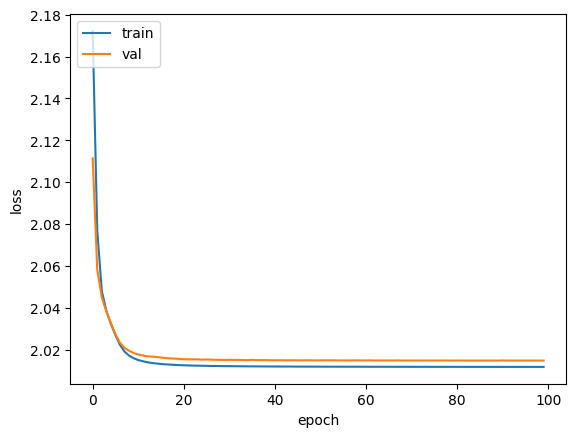

In [63]:
#@title Visualize training and validation LSTM model with only last hidden state
visualize_history(history_with_last_hidden)

In [64]:
#@title Check random samples LSTM model with only last hidden state
check_samples(trained_model_with_last_hidden, X_test, y_test, num_samples=10)

Input: [8, 8, 2, 2, 4, 7, 6, 5, 5, 5, 8, 9, 8, 3, 8, 0, 6, 7] 
Expected: [7, 6, 0, 8, 3, 8, 9, 8, 5, 5, 5, 6, 7, 4, 2, 2, 8, 8] 
Predicted: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8] 
False

Input: [3, 4, 9, 6, 3, 9, 7, 7, 5, 4, 4, 1, 6, 2, 8, 7, 3, 7] 
Expected: [7, 3, 7, 8, 2, 6, 1, 4, 4, 5, 7, 7, 9, 3, 6, 9, 4, 3] 
Predicted: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7] 
False

Input: [2, 1, 8, 1, 0, 3, 9, 3, 6, 2, 9, 2, 8, 9, 3, 7, 4, 0] 
Expected: [0, 4, 7, 3, 9, 8, 2, 9, 2, 6, 3, 9, 3, 0, 1, 8, 1, 2] 
Predicted: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3] 
False

Input: [8, 9, 8, 2, 3, 8, 7, 5, 1, 7, 3, 0, 4, 5, 1, 2, 2, 6] 
Expected: [6, 2, 2, 1, 5, 4, 0, 3, 7, 1, 5, 7, 8, 3, 2, 8, 9, 8] 
Predicted: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8] 
False

Input: [4, 8, 8, 3, 3, 9, 2, 6, 4, 2, 9, 3, 5, 1, 9, 7, 5, 1] 
Expected: [1, 5, 7, 9, 1, 5, 3, 9, 2, 4, 6, 2, 9, 3, 3, 8, 8, 4] 
Predicted: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

#3.2. LSTM model - Last hidden state and last cell state

Model: "model_LSTM_with_last_hidden_and_last_cell"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 18, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ [(None, 16),      │      1,728 │ input_layer_12[0… │
│                     │ (None, 16),       │            │                   │
│                     │ (None, 16)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_5     │ (None, 18, 16)    │          0 │ lstm_12[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 18, 16)    │      2,112 │ repeat_vector_5[… │
│                     │                   │            │ lstm_12[0][1],    │
│                     │                   │            │ lstm_12[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, 18, 10)    │        170 │ lstm_13[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,010 (15.66 KB)

 Trainable params: 4,010 (15.66 KB)

 Non-trainable params: 0 (0.00 B)

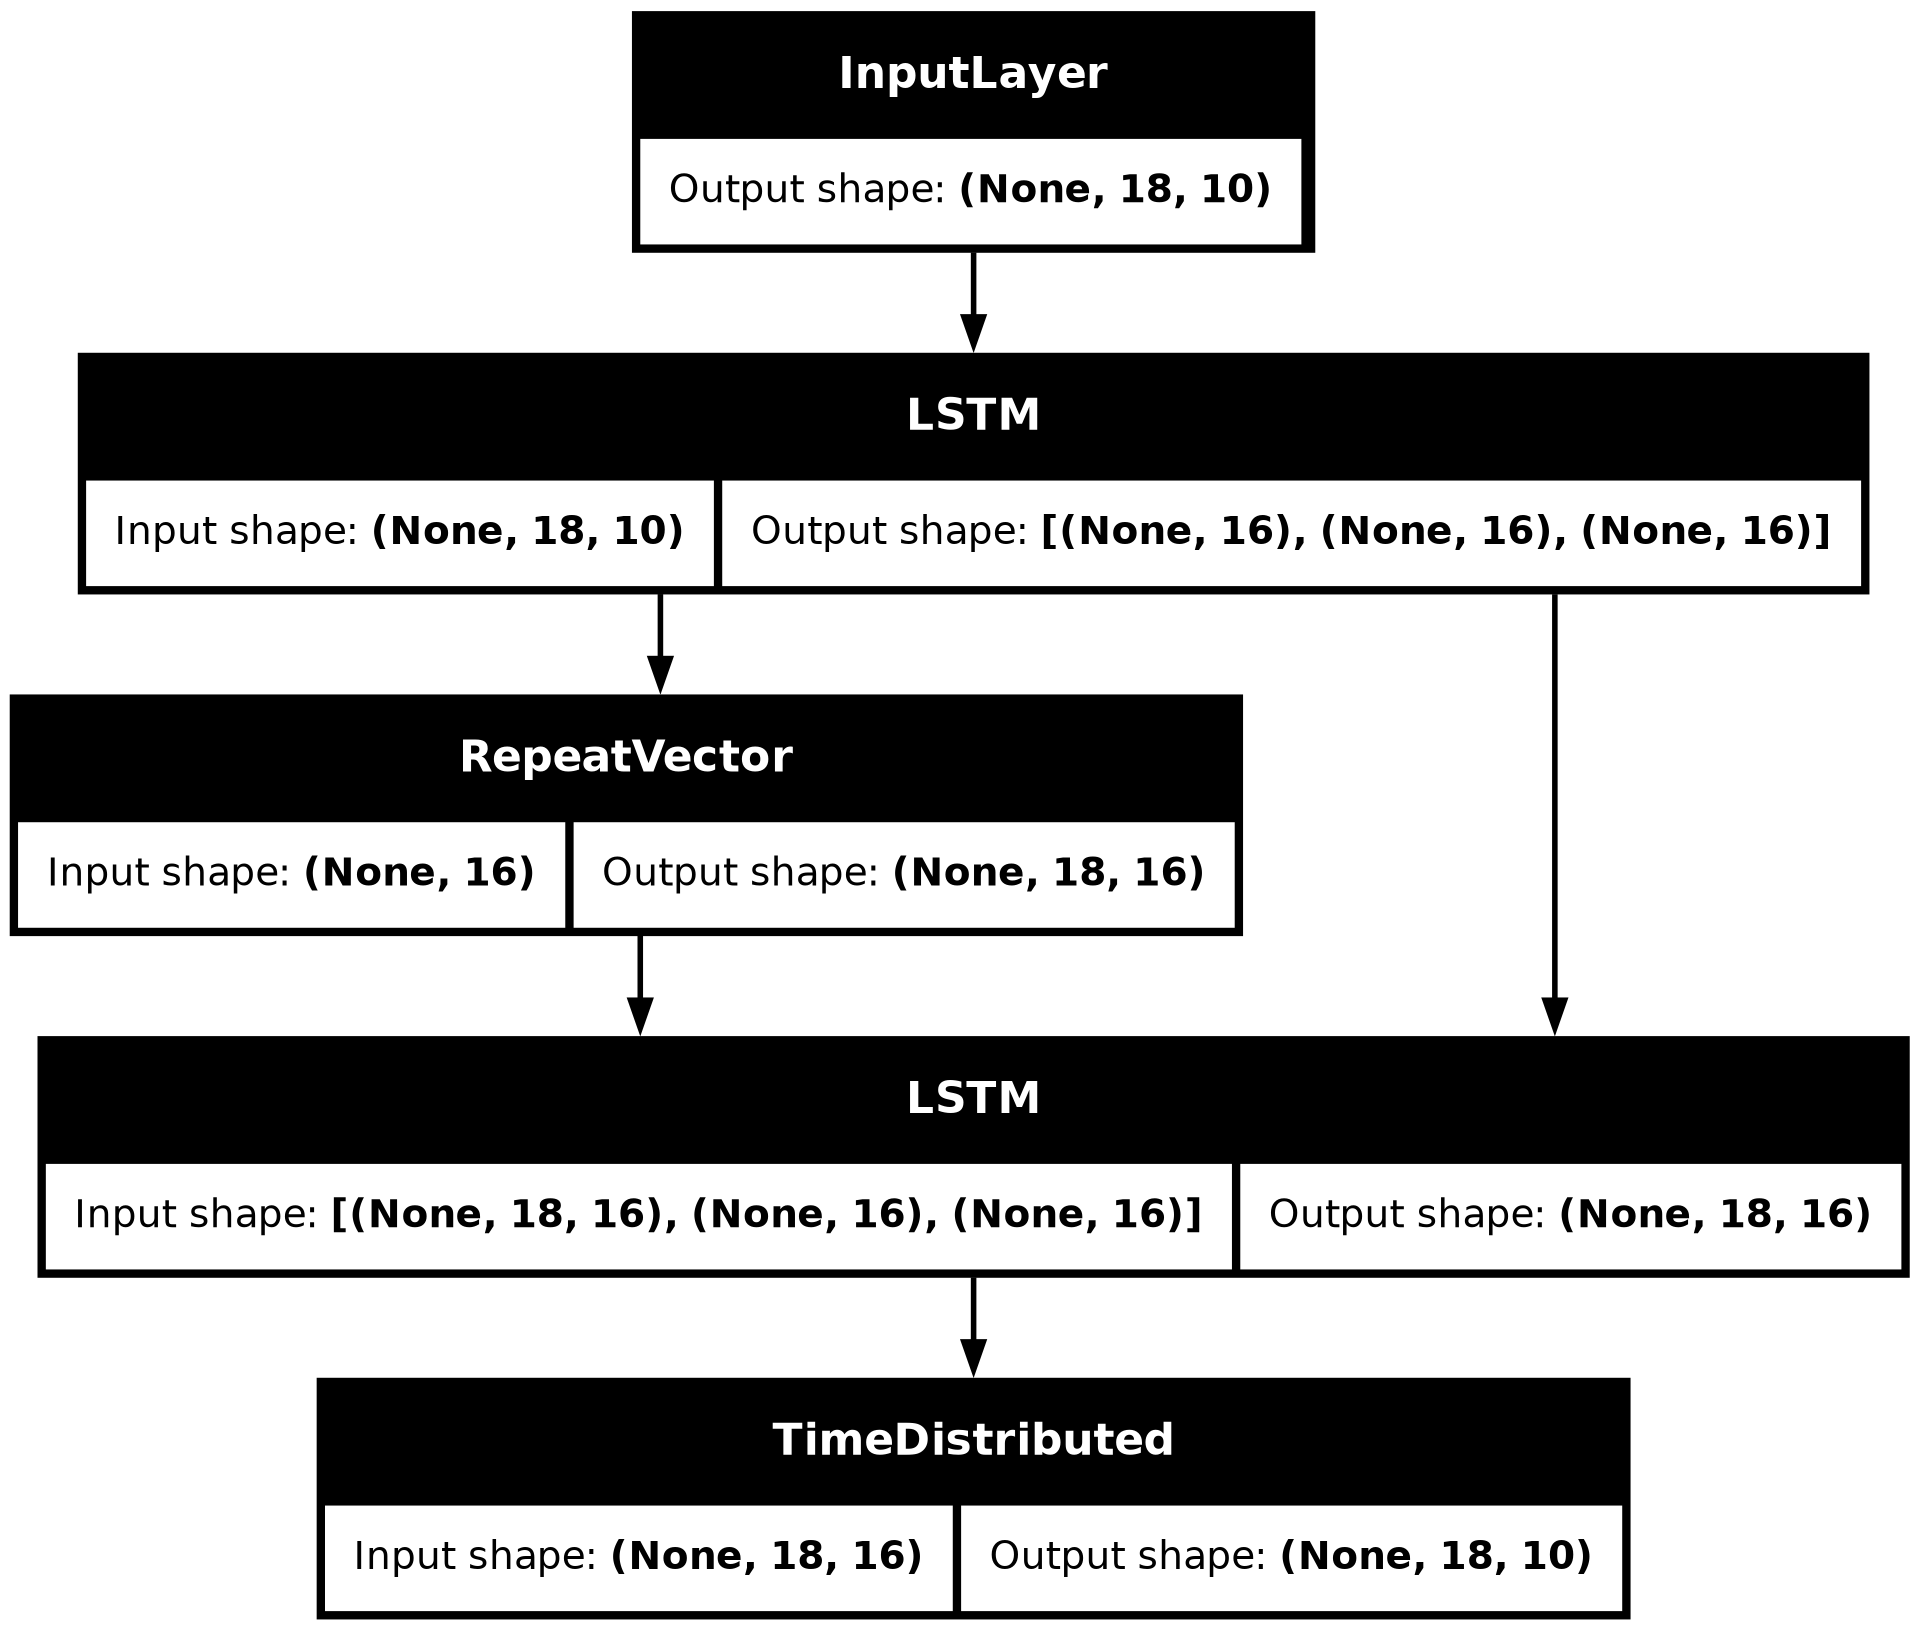

In [65]:
#@title Create LSTM model with last hidden state and last cell state
numberOfUnits = 16
input= Input(shape=(n_timesteps_in, n_features))

lstm1 = LSTM(numberOfUnits,return_state=True)
LSTM_output, state_h, state_c = lstm1(input)
states = [state_h, state_c]

repeat=RepeatVector(n_timesteps_in)
LSTM_output = repeat(LSTM_output)

lstm2 = LSTM(numberOfUnits,return_sequences=True)
all_state_h = lstm2(LSTM_output,initial_state=states)

dense = TimeDistributed(Dense(n_features, activation='softmax'))
output = dense(all_state_h)
model_LSTM_with_last_hidden_and_last_cell = Model(input,output,name='model_LSTM_with_last_hidden_and_last_cell')
model_LSTM_with_last_hidden_and_last_cell.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM_with_last_hidden_and_last_cell.summary()
plot_model(model_LSTM_with_last_hidden_and_last_cell,show_shapes=True)

In [66]:
#@title Train and Evaluate LSTM model with last hidden state and last cell state
trained_model_with_last_hidden_and_last_cell, history_with_last_hidden_and_last_cell = train_test(model_LSTM_with_last_hidden_and_last_cell, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 13s - 23ms/step - accuracy: 0.2030 - loss: 2.1601 - val_accuracy: 0.2372 - val_loss: 2.0702
Epoch 2/100
563/563 - 8s - 15ms/step - accuracy: 0.2547 - loss: 2.0282 - val_accuracy: 0.2648 - val_loss: 1.9923
Epoch 3/100
563/563 - 8s - 14ms/step - accuracy: 0.2767 - loss: 1.9594 - val_accuracy: 0.2812 - val_loss: 1.9356
Epoch 4/100
563/563 - 8s - 14ms/step - accuracy: 0.2898 - loss: 1.9153 - val_accuracy: 0.2893 - val_loss: 1.9022
Epoch 5/100
563/563 - 8s - 14ms/step - accuracy: 0.2960 - loss: 1.8890 - val_accuracy: 0.2941 - val_loss: 1.8824
Epoch 6/100
563/563 - 8s - 15ms/step - accuracy: 0.2990 - loss: 1.8712 - val_accuracy: 0.2969 - val_loss: 1.8669
Epoch 7/100
563/563 - 8s - 14ms/step - accuracy: 0.3018 - loss: 1.8578 - val_accuracy: 0.2974 - val_loss: 1.8559
Epoch 8/100
563/563 - 8s - 14ms/step - accuracy: 0.3033 - loss: 1.8477 - val_accuracy: 0.3004 - 

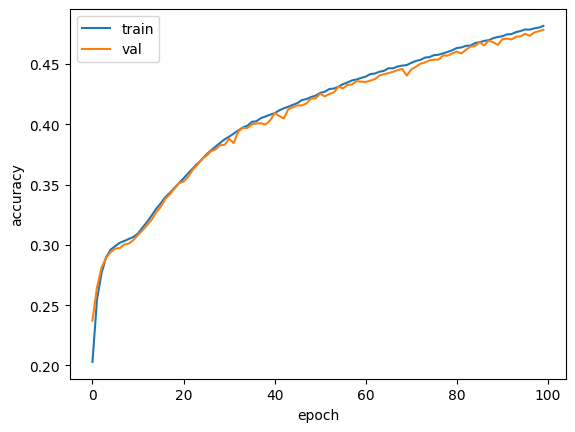

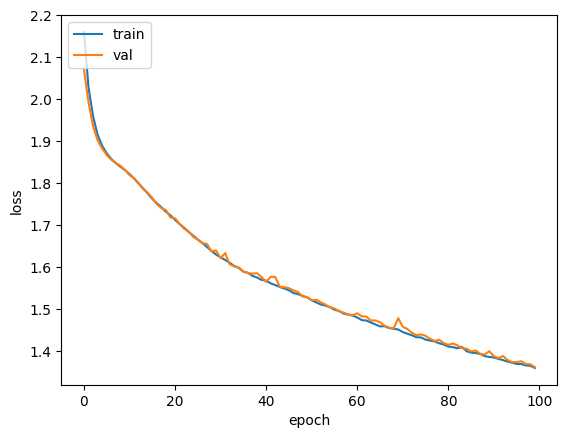

In [67]:
#@title Visualize training and validation LSTM model with last hidden state and last cell state
visualize_history(history_with_last_hidden_and_last_cell)

In [68]:
#@title Check random samples LSTM model with last hidden state and last cell state
check_samples(trained_model_with_last_hidden_and_last_cell, X_test, y_test, num_samples=10)

Input: [2, 1, 7, 9, 9, 5, 4, 1, 5, 3, 2, 6, 8, 4, 1, 1, 4, 3] 
Expected: [3, 4, 1, 1, 4, 8, 6, 2, 3, 5, 1, 4, 5, 9, 9, 7, 1, 2] 
Predicted: [3, 4, 1, 1, 8, 8, 8, 5, 1, 1, 1, 1, 2, 2, 9, 7, 9, 9] 
False

Input: [8, 2, 6, 0, 6, 7, 5, 3, 4, 9, 8, 2, 4, 6, 4, 9, 2, 8] 
Expected: [8, 2, 9, 4, 6, 4, 2, 8, 9, 4, 3, 5, 7, 6, 0, 6, 2, 8] 
Predicted: [8, 2, 2, 4, 9, 9, 9, 9, 9, 6, 6, 8, 7, 8, 0, 8, 8, 8] 
False

Input: [6, 1, 9, 8, 4, 4, 1, 8, 5, 0, 0, 9, 7, 9, 7, 5, 1, 9] 
Expected: [9, 1, 5, 7, 9, 7, 9, 0, 0, 5, 8, 1, 4, 4, 8, 9, 1, 6] 
Predicted: [9, 1, 9, 7, 9, 7, 1, 0, 0, 1, 1, 1, 1, 8, 8, 1, 1, 1] 
False

Input: [3, 4, 6, 9, 5, 8, 1, 7, 1, 5, 7, 6, 4, 9, 5, 4, 3, 4] 
Expected: [4, 3, 4, 5, 9, 4, 6, 7, 5, 1, 7, 1, 8, 5, 9, 6, 4, 3] 
Predicted: [4, 3, 4, 4, 5, 5, 5, 7, 5, 1, 5, 7, 3, 3, 3, 3, 3, 3] 
False

Input: [2, 6, 9, 6, 8, 6, 7, 5, 3, 6, 9, 6, 9, 1, 6, 5, 4, 5] 
Expected: [5, 4, 5, 6, 1, 9, 6, 9, 6, 3, 5, 7, 6, 8, 6, 9, 6, 2] 
Predicted: [5, 2, 5, 6, 1, 3, 3, 3, 6, 6, 6, 7, 6, 6, 6, 6,

#3.3. LSTM model - All hidden states and last cell state

Model: "model_LSTM_with_all_hidden_and_last_cell"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 18, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ [(None, 18, 16),  │      1,728 │ input_layer_13[0… │
│                     │ (None, 16),       │            │                   │
│                     │ (None, 16)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 18, 16)    │      2,112 │ lstm_14[0][0],    │
│                     │                   │            │ lstm_14[0][1],    │
│                     │                   │            │ lstm_14[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 18, 10)    │        170 │ lstm_15[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,010 (15.66 KB)

 Trainable params: 4,010 (15.66 KB)

 Non-trainable params: 0 (0.00 B)

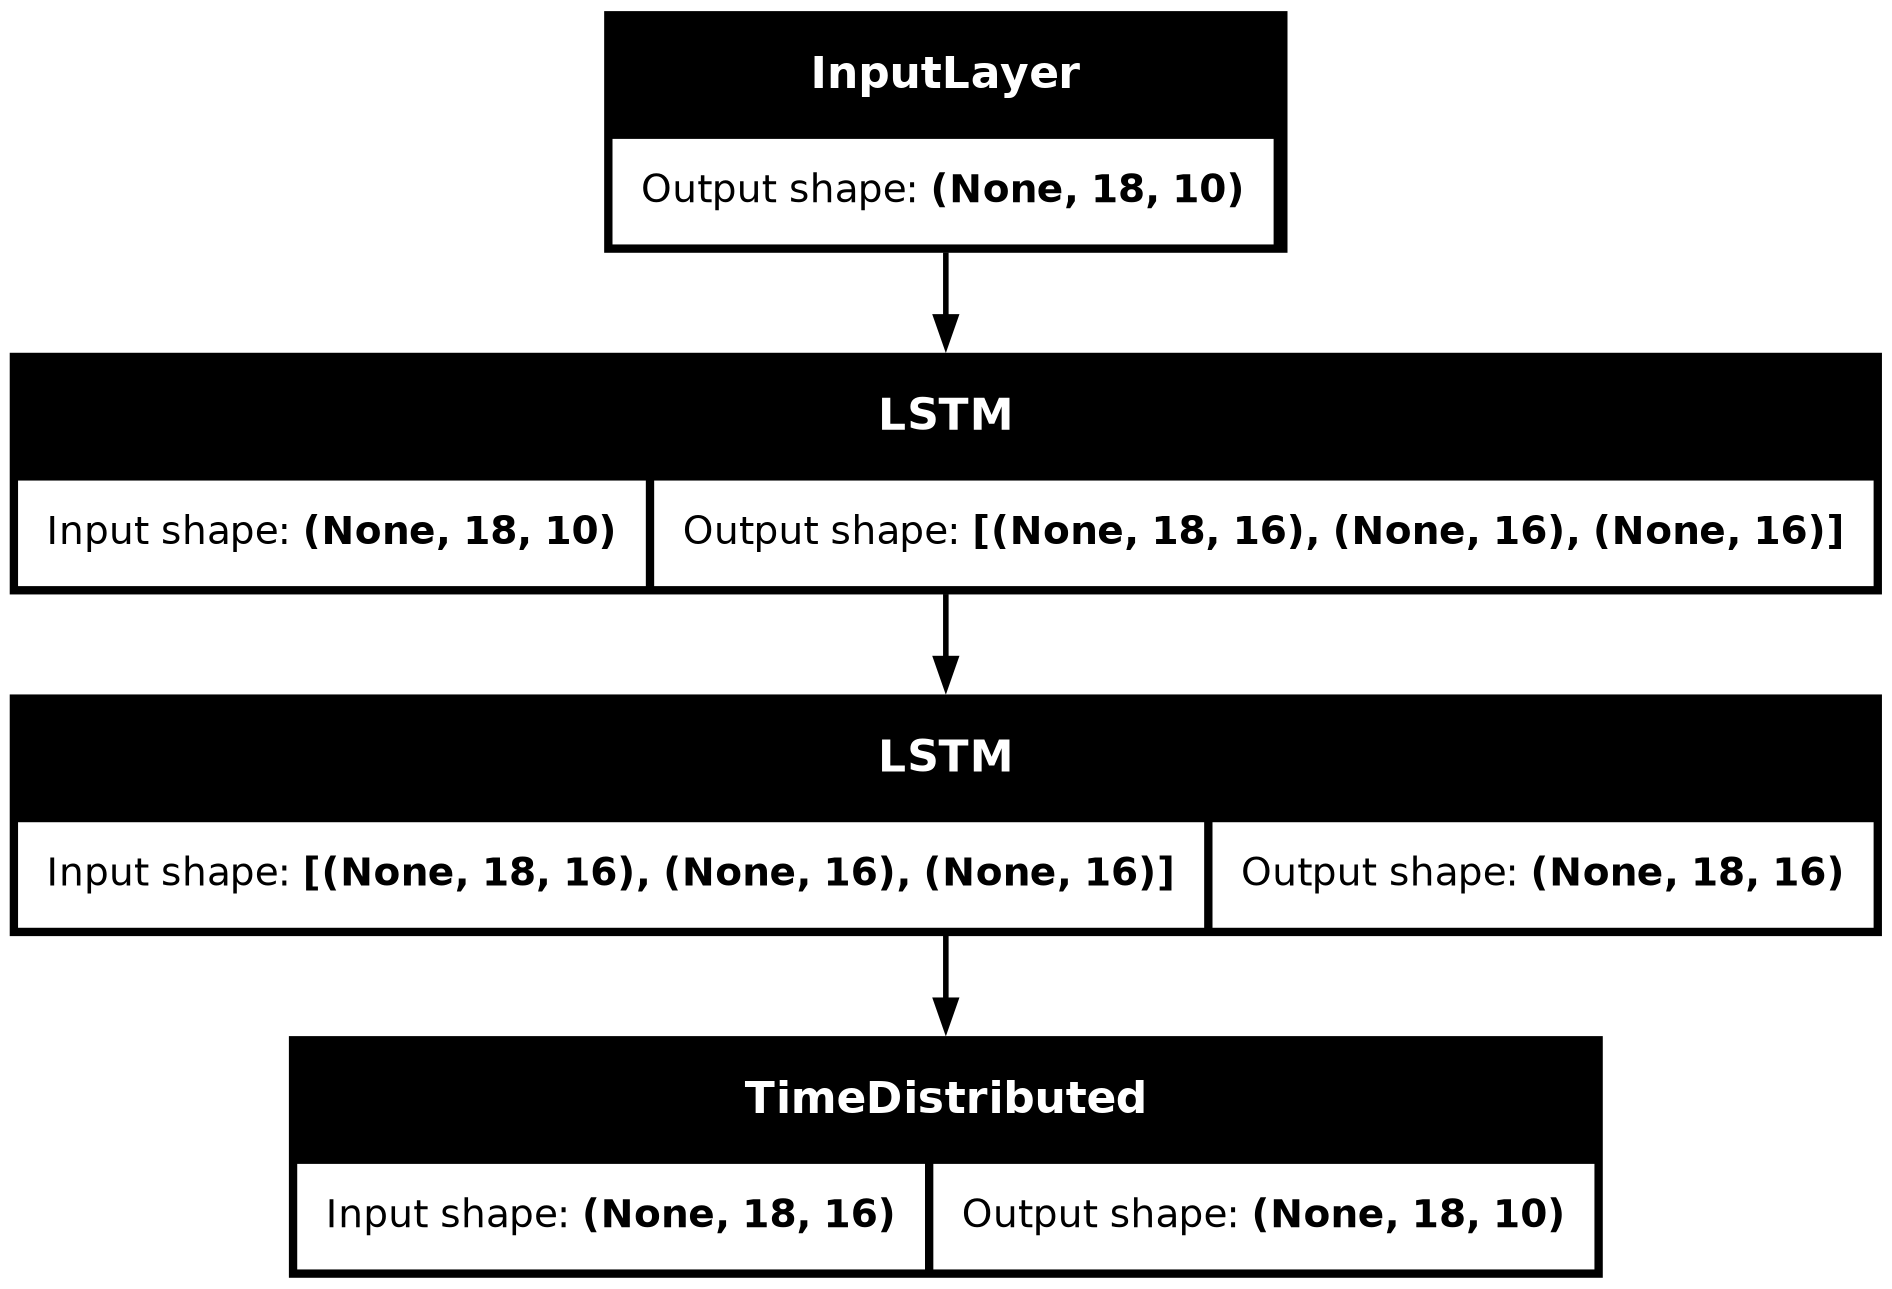

In [69]:
#@title Create LSTM model with all hidden states and last cell state
numberOfUnits = 16
input= Input(shape=(n_timesteps_in, n_features))

lstm1 = LSTM(numberOfUnits,return_sequences=True, return_state=True)
all_state_h, state_h, state_c = lstm1(input)
states = [state_h, state_c]

lstm2 = LSTM(numberOfUnits,return_sequences=True)
all_state_h = lstm2(all_state_h,initial_state=states)

dense = TimeDistributed(Dense(n_features, activation='softmax'))
output = dense(all_state_h)
model_LSTM_with_all_hidden_and_last_cell = Model(input,output, name='model_LSTM_with_all_hidden_and_last_cell')
model_LSTM_with_all_hidden_and_last_cell.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM_with_all_hidden_and_last_cell.summary()
plot_model(model_LSTM_with_all_hidden_and_last_cell,show_shapes=True)

In [70]:
#@title Train and Evaluate LSTM model with all hidden states and last cell state
trained_model_with_all_hidden_and_last_cell, history_with_all_hidden_and_last_cell = train_test(model_LSTM_with_all_hidden_and_last_cell, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 14s - 24ms/step - accuracy: 0.2025 - loss: 2.1588 - val_accuracy: 0.2448 - val_loss: 2.0554
Epoch 2/100
563/563 - 8s - 14ms/step - accuracy: 0.2660 - loss: 2.0022 - val_accuracy: 0.2769 - val_loss: 1.9637
Epoch 3/100
563/563 - 8s - 14ms/step - accuracy: 0.2901 - loss: 1.9271 - val_accuracy: 0.2984 - val_loss: 1.9008
Epoch 4/100
563/563 - 8s - 14ms/step - accuracy: 0.3050 - loss: 1.8758 - val_accuracy: 0.3091 - val_loss: 1.8607
Epoch 5/100
563/563 - 8s - 14ms/step - accuracy: 0.3150 - loss: 1.8432 - val_accuracy: 0.3170 - val_loss: 1.8310
Epoch 6/100
563/563 - 8s - 14ms/step - accuracy: 0.3224 - loss: 1.8169 - val_accuracy: 0.3228 - val_loss: 1.8064
Epoch 7/100
563/563 - 8s - 15ms/step - accuracy: 0.3284 - loss: 1.7936 - val_accuracy: 0.3289 - val_loss: 1.7892
Epoch 8/100
563/563 - 10s - 18ms/step - accuracy: 0.3355 - loss: 1.7720 - val_accuracy: 0.3366 -

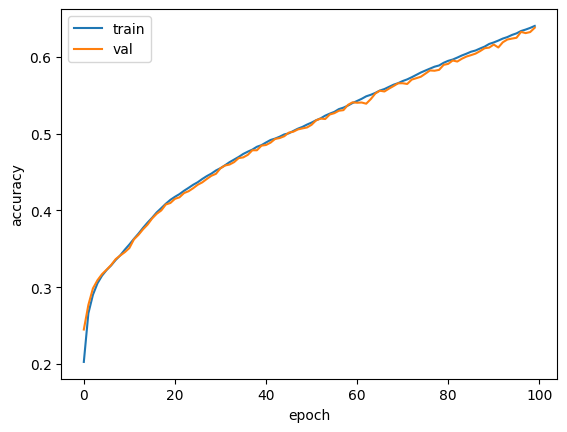

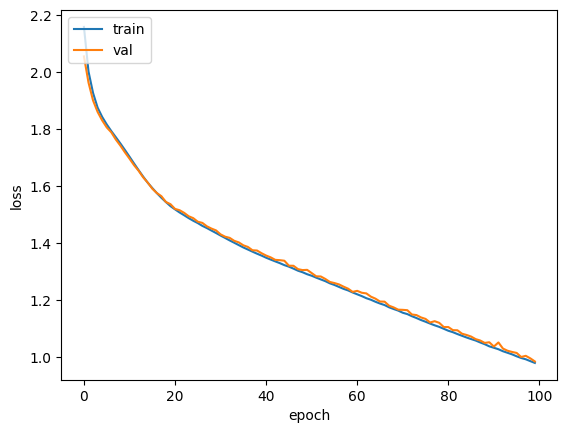

In [71]:
#@title Visualize training and validation LSTM model with all hidden states and last cell state
visualize_history(history_with_all_hidden_and_last_cell)

In [72]:
#@title Check random samples LSTM model with all hidden states and last cell state
check_samples(trained_model_with_all_hidden_and_last_cell, X_test, y_test, num_samples=10)

Input: [6, 1, 1, 5, 1, 4, 6, 2, 0, 1, 0, 2, 8, 1, 7, 6, 5, 6] 
Expected: [6, 5, 6, 7, 1, 8, 2, 0, 1, 0, 2, 6, 4, 1, 5, 1, 1, 6] 
Predicted: [6, 5, 0, 5, 1, 9, 2, 2, 4, 0, 2, 0, 5, 1, 1, 1, 1, 6] 
False

Input: [7, 0, 3, 8, 8, 1, 5, 5, 9, 6, 6, 9, 1, 9, 3, 3, 9, 0] 
Expected: [0, 9, 3, 3, 9, 1, 9, 6, 6, 9, 5, 5, 1, 8, 8, 3, 0, 7] 
Predicted: [0, 5, 3, 3, 9, 1, 1, 9, 1, 9, 5, 1, 1, 1, 8, 7, 0, 3] 
False

Input: [5, 6, 3, 4, 2, 3, 0, 1, 6, 5, 6, 7, 6, 0, 1, 3, 9, 2] 
Expected: [2, 9, 3, 1, 0, 6, 7, 6, 5, 6, 1, 0, 3, 2, 4, 3, 6, 5] 
Predicted: [2, 9, 3, 1, 0, 6, 7, 8, 4, 6, 1, 0, 2, 3, 3, 3, 3, 5] 
False

Input: [0, 4, 6, 7, 1, 8, 9, 2, 7, 3, 0, 9, 0, 7, 9, 4, 3, 9] 
Expected: [9, 3, 4, 9, 7, 0, 9, 0, 3, 7, 2, 9, 8, 1, 7, 6, 4, 0] 
Predicted: [9, 3, 6, 8, 7, 7, 7, 0, 7, 7, 2, 7, 8, 8, 6, 3, 3, 0] 
False

Input: [6, 6, 2, 2, 7, 2, 5, 4, 0, 7, 5, 0, 3, 3, 5, 1, 9, 9] 
Expected: [9, 9, 1, 5, 3, 3, 0, 5, 7, 0, 4, 5, 2, 7, 2, 2, 6, 6] 
Predicted: [9, 1, 1, 5, 3, 0, 0, 8, 4, 0, 5, 8, 2, 2, 2, 6,

#Reference
1. https://www.muratkarakaya.net/2022/11/seq2seq-learning-tutorial-series.html
2. https://deeplearningmath.org/sequence-models.html
